# Projeto 2

Este projeto consiste em testar a possibilidade de detectar o número aproximado de estrelas na imagem através dos picos de luminosidade produzidos pelas estrelas em relação ao fluxo do fundo do céu. Seguiremos os seguintes passos:

1º - Selecionar uma área livre de estrelas e calcular o fluxo médio do céu, se possível.

2º - Calcular o Sinal/Ruído e somar o resultado multiplicado por 3 ao fluxo do céu obtido anteriormente, de modo a termos um intervalo de confiança razoável.

3º - Criar uma máscara e aplicá-la em uma cópia da imagem principal a qual receberá valor 0 nos pixels com fluxo abaixo do fluxo do céu.

4º - Agrupar os pixels > fluxo do céu mais próximos, de maneira a definir grupos de estrelas.

5º - Contar o número de grupos de pixels gerados, o qual nos dará o número de estrelas.

6º - Plotar marcações nas coordenadas pertencentes aos fluxos das estrelas encontradas na imagem principal.

7º - Plotar individualmente cada estrela encontrada em um gráfico de curva de nível para verificarmos suas luminosidades



## Importando bibliotecas

In [ ]:
import scipy.optimize as opt
import numpy as np
import pylab as plt
import astropy.io.fits as fits
from scipy.ndimage import label

## Criando classe para processamento da imagem

In [111]:
class ProcessImage():
  """Classe com método auxiliares para o tratamento e análise da imagem"""

  def __init__(self, path_image: str):
    self.path_image = path_image
    self.imagem = self.load_image()


  def load_image(self):
    """
    Função para carregar a imagem a ser tratada
    """
    try:
      imagem = fits.getdata(self.path_image).astype(float)
      return imagem
    except FileNotFoundError:
      raise FileNotFoundError("Arquivo não encontrado.")


  def plotar_imagem(self, dvmin: int, dvmax: int, color_map = 'gray'):
    """
    Função para plotar a imagem carregada pelo objeto da classe
    """

    plt.figure(figsize=[10, 6])
    plt.imshow(self.imagem, cmap = color_map, vmin = self.imagem.mean()-dvmin, vmax = self.imagem.mean()+dvmax)
    plt.show()


  def detectar_pixels_aglomerados(self, imagem: np.ndarray):
    """
    Função que detecta e aglomera pixels por proximidade, auxiliando no agrupamento de pixels pertencentes
    a uma mesma estrela.

    Parameters
    ----------
      imagem : numpy.ndarray
        imagem a ser processada

    Returns
    -------
    numpy.ndarray
    """

    rotulos, num_rotulos = label(imagem)
    coordenadas_aglomerados = [np.argwhere(rotulos == i) for i in range(1, num_rotulos + 1)]

    aglomerados = []
    for i, coords in enumerate(coordenadas_aglomerados):
        estrela = []
        for coord in coords:
          estrela.append(coord)

        aglomerados.append(estrela)

    aglomerados = np.array(aglomerados)
    return aglomerados


  def plotar_curva_de_nivel(self, imagem: np.ndarray, coord_x: list, coord_y: list, label='', scatter=True):
    """
    Função que tem por finalidade plotar gráficos de curva de nível do tipo (x, y, luminosidade)

    Parameters
    ----------
      imagem : numpy.ndarray
        imagem a ser processada
      coord_x: list
        coordenadas x dos pontos a serem plotados
      coord_y: list
        coordenadas y dos pontos a serem plotados
      label: str
        nomeação dos pontos plotados
      scatter: bool
        booleano para a opção de marcar as coordenadas especificadas ou não

    Returns
    -------
    None
    """

    plt.contourf(imagem, cmap='viridis')
    plt.colorbar()

    if scatter:
      plt.scatter(coord_x, coord_y, c='red', marker='o', s=1, label=label)
      plt.legend()

    plt.show()

  def plotar_estrelas(self, lista_estrelas: np.ndarray, option = 0):
    """
    Função responsável por plotar a lista de estrelas detectadas.

    Parameters
    ----------
      lista_estrelas : numpy.ndarray
        lista de estrelas com seus pixels agrupados
      option: bool
        value 0: plotagem de todas as estrelas na imagem
        value 1: plotagem individual das estrelas em recortes da imagem principal

    Returns
        -------
    numpy.ndarray
    """

    if option == 0:
      coordenadas_x = [ponto[1] for grupo in lista_estrelas for ponto in grupo]
      coordenadas_y = [ponto[0] for grupo in lista_estrelas for ponto in grupo]

      self.plotar_curva_de_nivel(self.imagem, coordenadas_x, coordenadas_y, 'Picos')


    elif option == 1:
      for i in range(len(lista_estrelas)):
        coordenadas_x = [ponto[0] for ponto in lista_coord_estrelas[i]]
        coordenadas_y = [ponto[1] for ponto in lista_coord_estrelas[i]]

        max_coord_x = np.max(coordenadas_x)
        min_coord_x = np.min(coordenadas_x)
        max_coord_y = np.max(coordenadas_y)
        min_coord_y = np.min(coordenadas_y)

        print(f"Estrela {i+1}: ")
        self.plotar_curva_de_nivel(self.imagem[min_coord_x-30 : max_coord_x+30, min_coord_y-30 : max_coord_y+30],
                                 coordenadas_x,
                                 coordenadas_y,
                                 scatter=False
                                   )




In [133]:
# Instanciando o objeto da classe ProcessImage e carregando a imagem

path_image = 'Image_2.fits'
pImage = ProcessImage(path_image)

In [134]:
# Dimensões da imagem
pImage.imagem.shape

(2048, 2048)

## Determinando o fluxo do fundo do céu

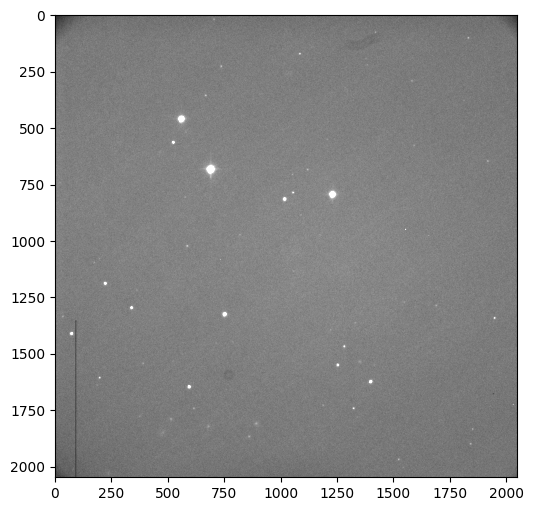

In [117]:
pImage.plotar_imagem(100, 100)

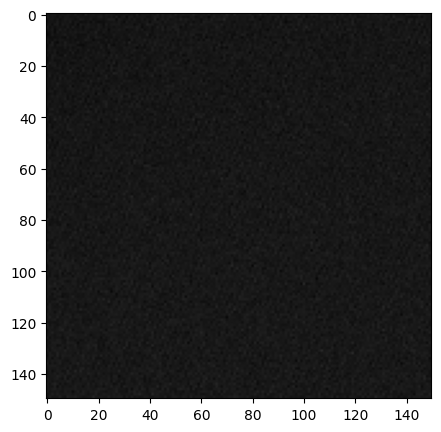

In [118]:
# Selecionando uma parte da imagem aparentemente sem estrelas

new_image = pImage.imagem[0:150, 100:250]

plt.figure(figsize=[5, 5])
plt.imshow(new_image, cmap='gray', vmin=new_image.mean()-100, vmax=new_image.mean()+1000)
plt.show()

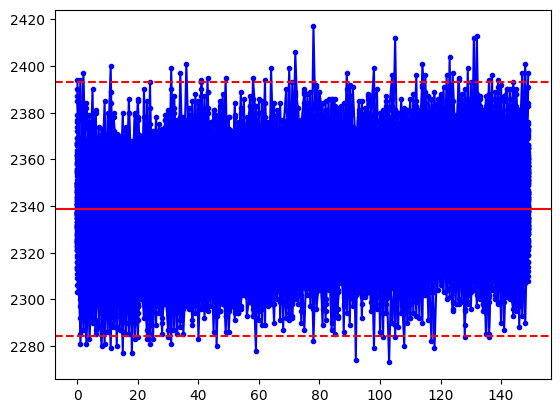

In [119]:
# Verificando a existência de picos de luminosidade que apontariam possiveis estrelas na imagem

amostra_ceu = pImage.imagem[0:150, 100:250]
plt.plot(amostra_ceu, 'b.-')

plt.axhline(amostra_ceu.mean(), color='red')
plt.axhline(amostra_ceu.mean() + 3.0*amostra_ceu.std(), color='red', ls='--')
plt.axhline(amostra_ceu.mean() - 3.0*amostra_ceu.std(), color='red', ls='--')
plt.show()

Podemos ver que esta área da imagem não possui nenhum grande pico de luminosidade e no geral fica dentro do intervalo de confiança de 3 sigmas, então podemos prosseguir com ela.

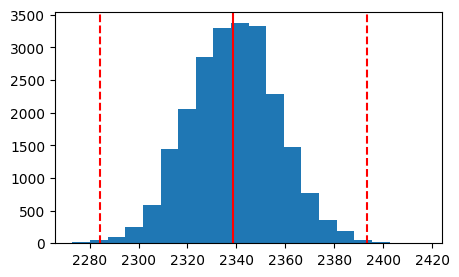

In [120]:
# Distribuição da luminosidade por pixel na imagem

plt.figure(figsize=[5,3])

plt.hist(amostra_ceu.flatten(), 20)

plt.axvline(amostra_ceu.mean(), color='red')
plt.axvline(amostra_ceu.mean() + 3*amostra_ceu.std(), color='red', ls='--')
plt.axvline(amostra_ceu.mean() - 3*amostra_ceu.std(), color='red', ls='--')

plt.show()

In [121]:
flux_sky = np.sum(amostra_ceu)
print('Flux do céu:', flux_sky)

npix_sky = len(amostra_ceu.flatten())
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu: {:.2f} +/- {:.2f}'.format(amostra_ceu.mean(),
                                                               amostra_ceu.std()))

Flux do céu: 52623277.0
Número de pixeis: 22500


Distribuição do Fundo do céu: 2338.81 +/- 18.14


In [122]:
# Definindo S/N do fundo do céu e o fluxo com intervalo de confiança
sn_ceu = np.sqrt(amostra_ceu.mean())
fluxo_ceu = amostra_ceu.mean() + 3*sn_ceu
print('S/N do céu: {:.2f}'.format(sn_ceu))
print('Fluxo + (3 X S/N) do céu: {:.2f}'.format(fluxo_ceu))

S/N do céu: 48.36
Fluxo + (3 X S/N) do céu: 2483.90


## Encontrando o número de estrelas na imagem

In [126]:
# Criando máscara e uma cópia auxiliar da imagem
mask = pImage.imagem < fluxo_ceu
imagem_copy = pImage.imagem.copy()
imagem_copy[mask] = 0

In [128]:
# Separando pixels aglomerados
lista_coord_estrelas = pImage.detectar_pixels_aglomerados(imagem_copy)

<ipython-input-111-7cc0c8397bd7>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aglomerados = np.array(aglomerados)


In [129]:
# Número de estrelas encontradas

print(f"Número de estrelas detectadas: {len(lista_coord_estrelas)}")

Número de estrelas detectadas: 50


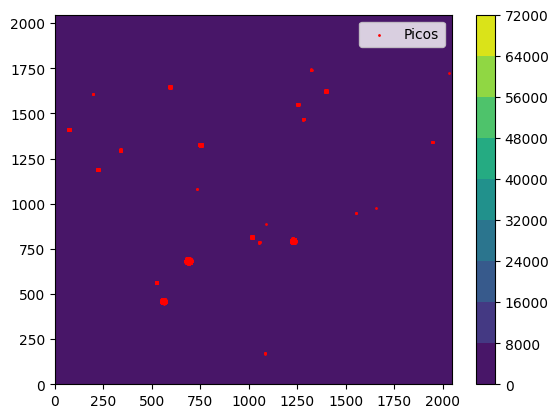

In [130]:
# Plotando as posições das estrelas na imagem

pImage.plotar_estrelas(lista_coord_estrelas, option=0)

Estrela 1: 


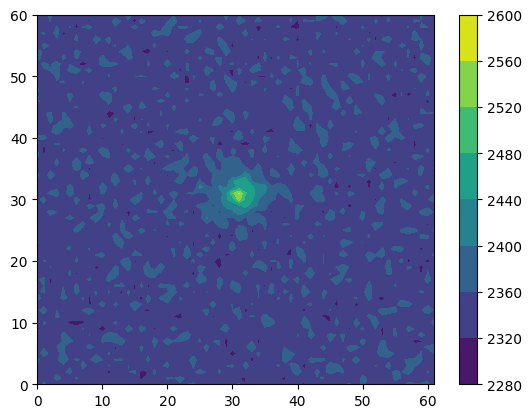

Estrela 2: 


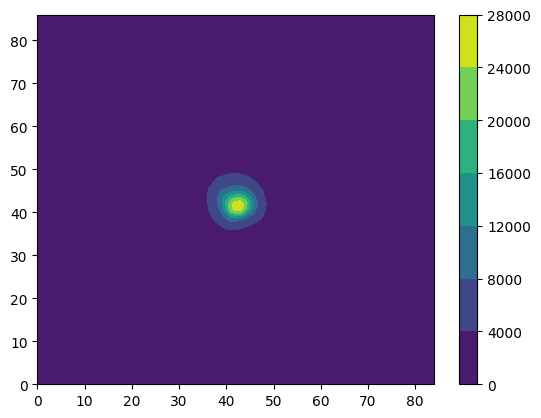

Estrela 3: 


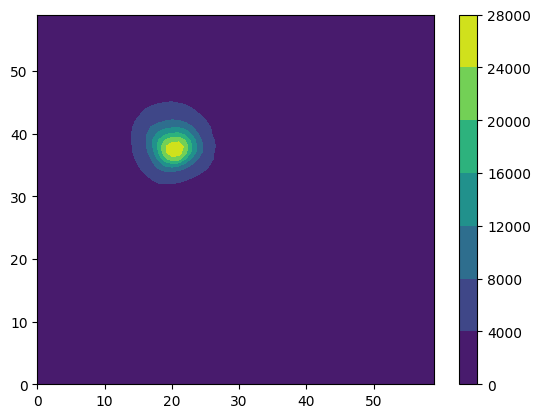

Estrela 4: 


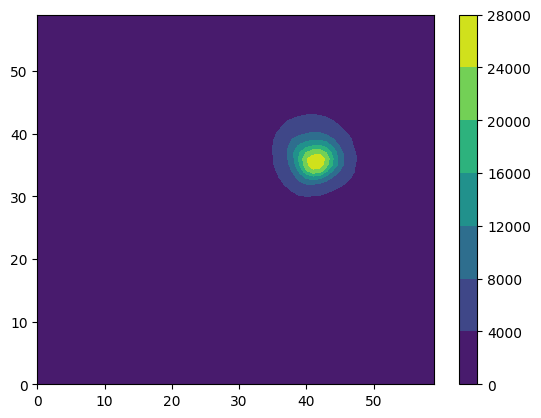

Estrela 5: 


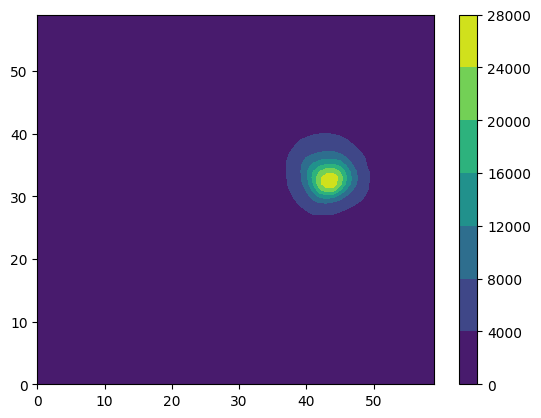

Estrela 6: 


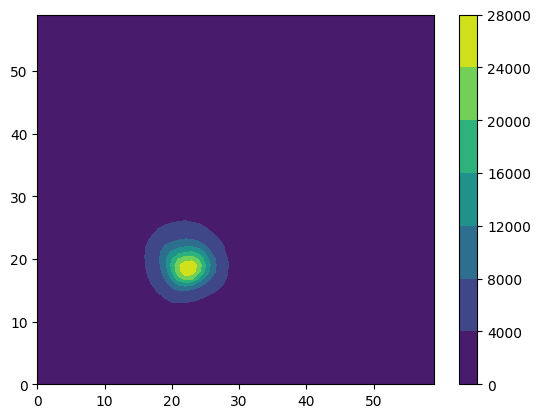

Estrela 7: 


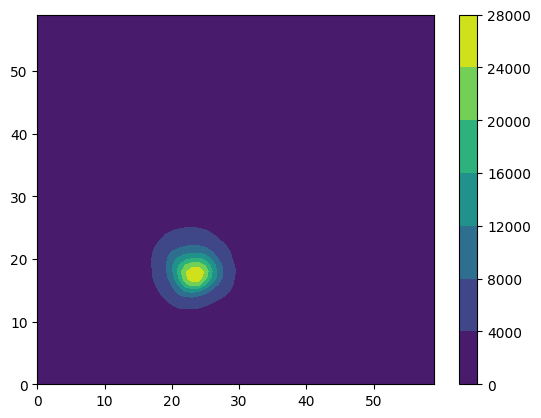

Estrela 8: 


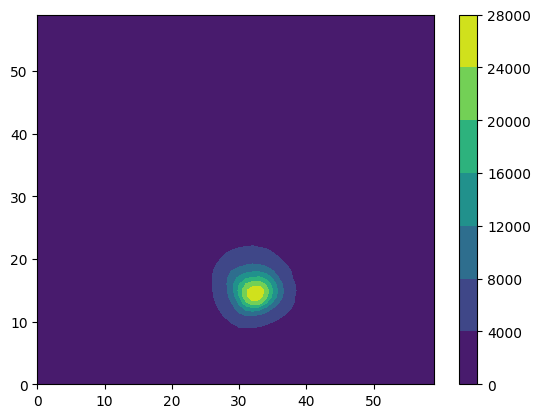

Estrela 9: 


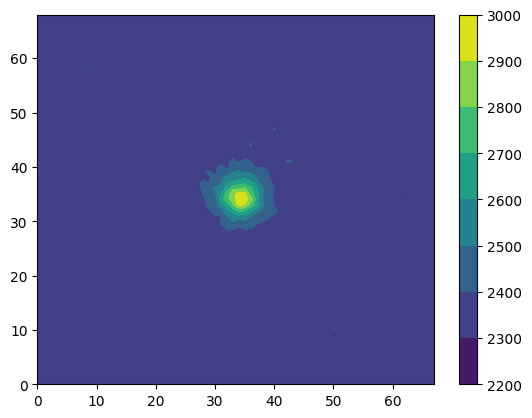

Estrela 10: 


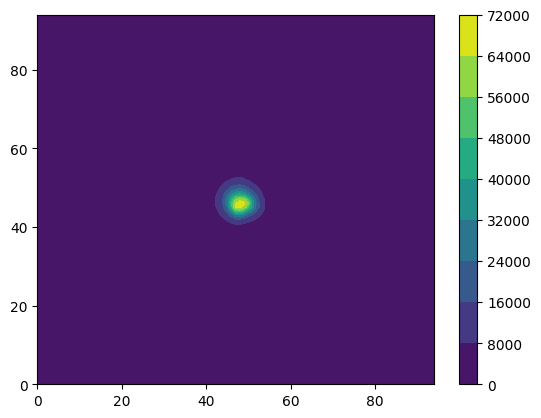

Estrela 11: 


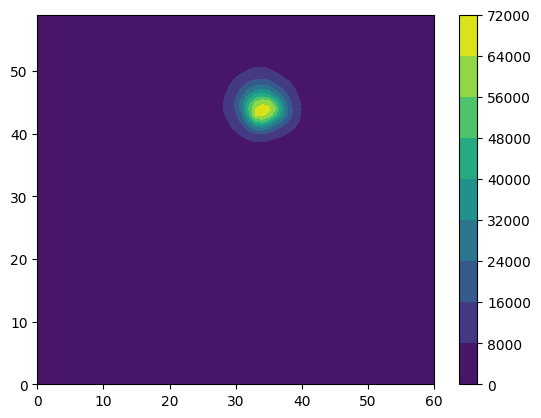

Estrela 12: 


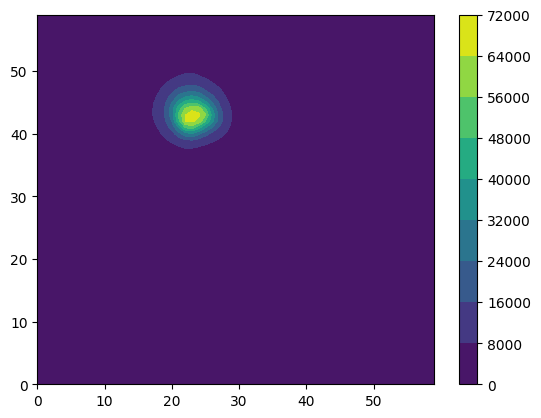

Estrela 13: 


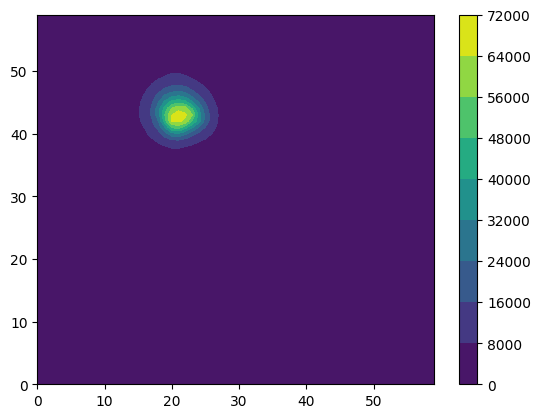

Estrela 14: 


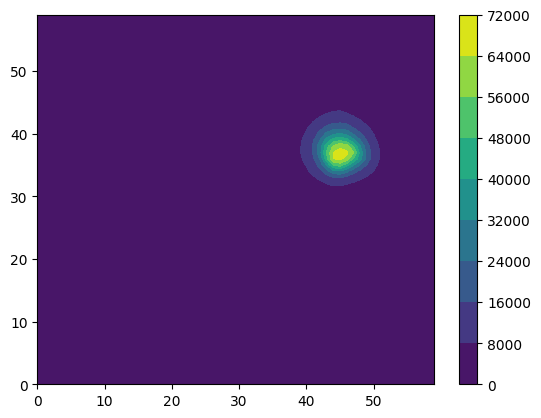

Estrela 15: 


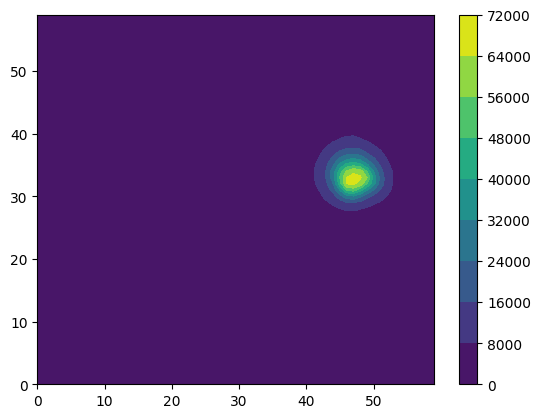

Estrela 16: 


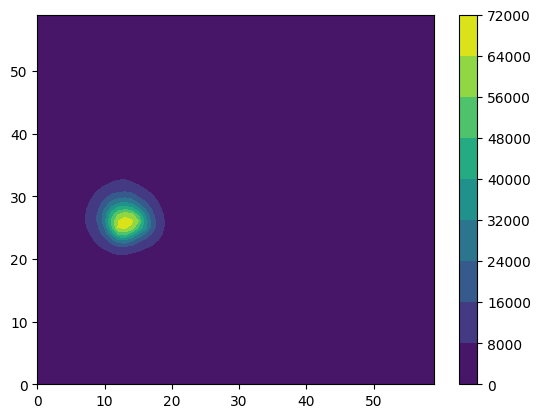

Estrela 17: 


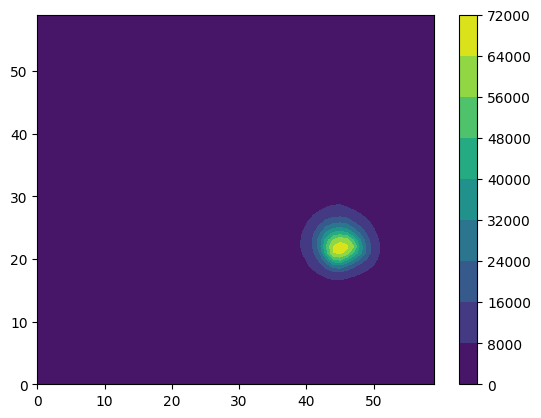

Estrela 18: 


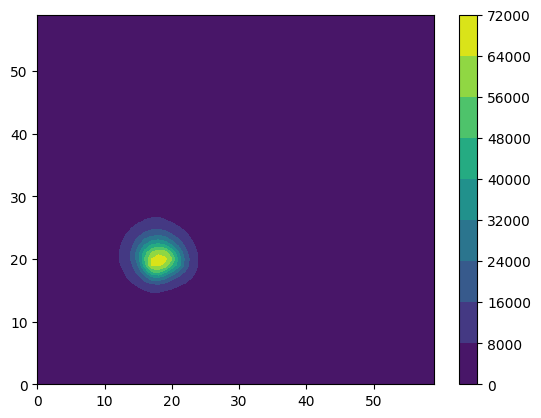

Estrela 19: 


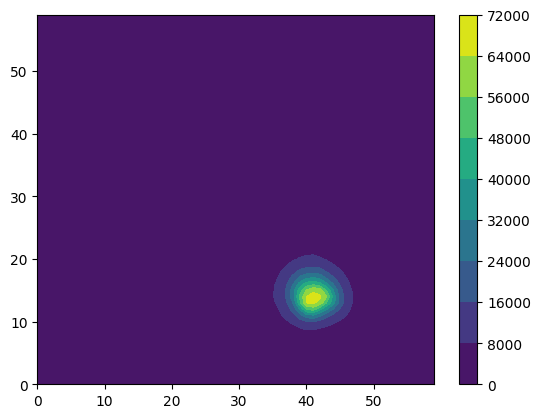

Estrela 20: 


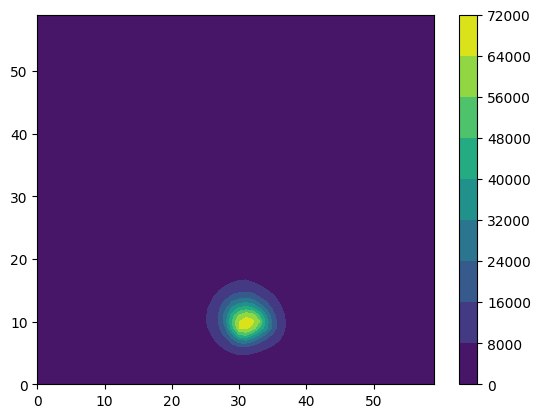

Estrela 21: 


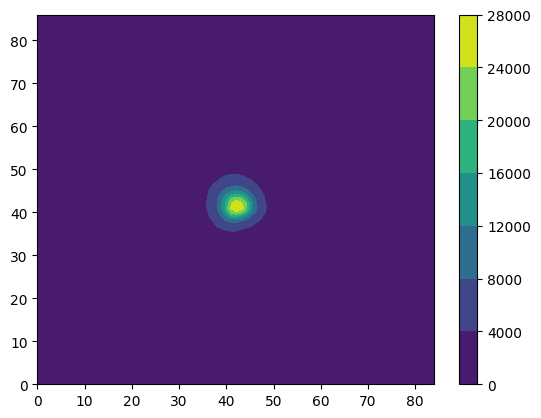

Estrela 22: 


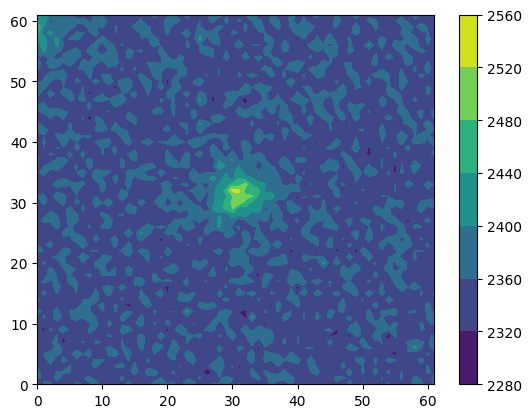

Estrela 23: 


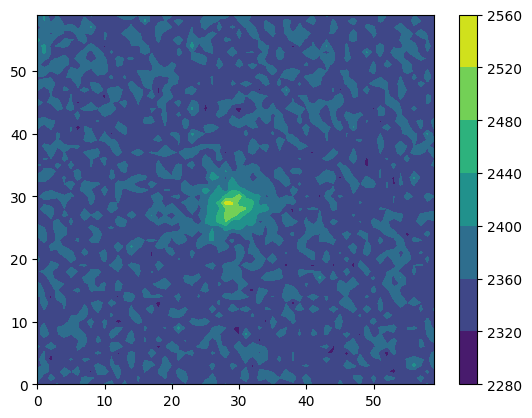

Estrela 24: 


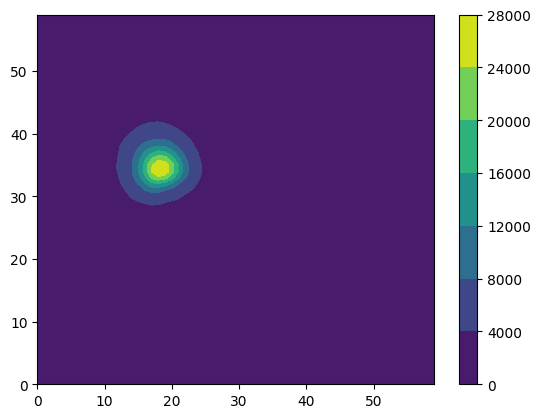

Estrela 25: 


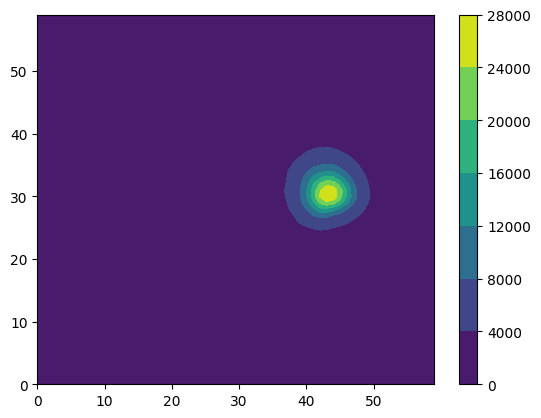

Estrela 26: 


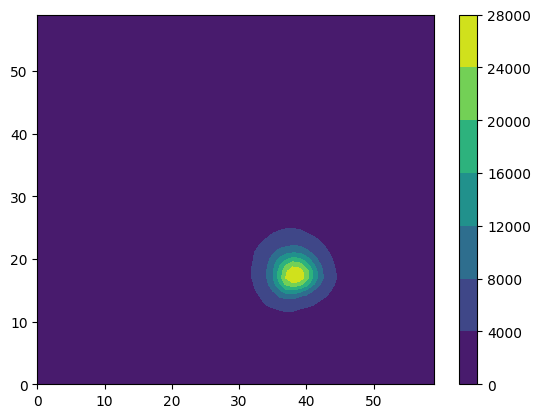

Estrela 27: 


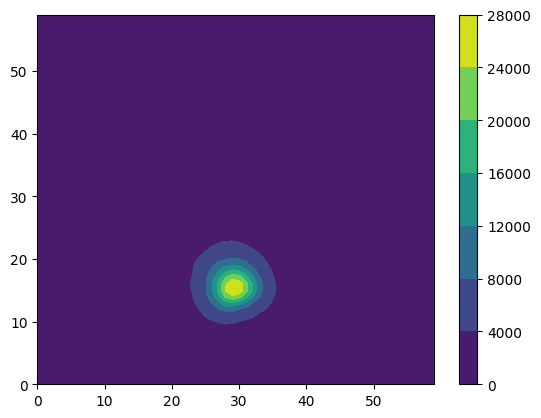

Estrela 28: 


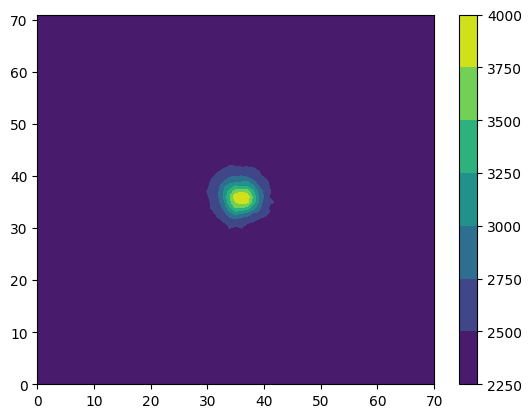

Estrela 29: 


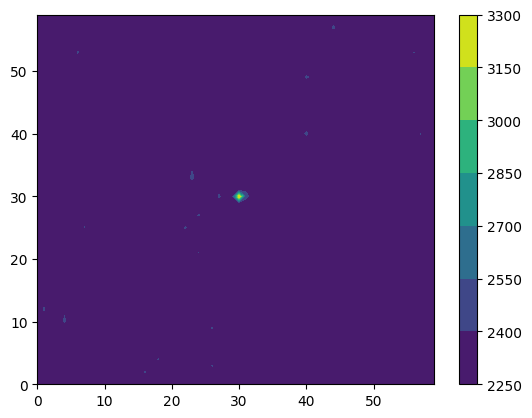

Estrela 30: 


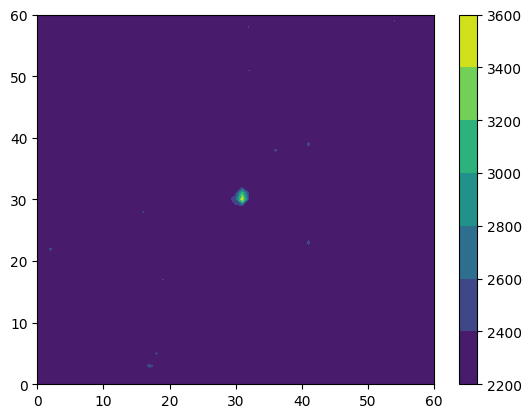

Estrela 31: 


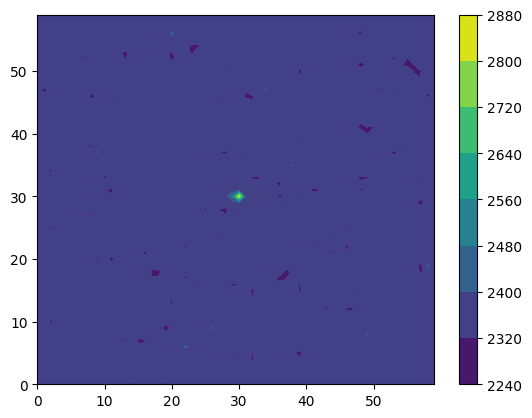

Estrela 32: 


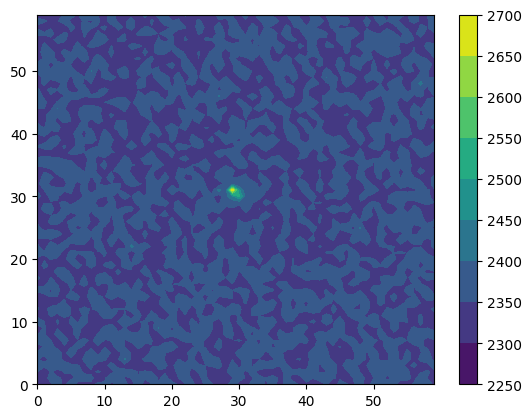

Estrela 33: 


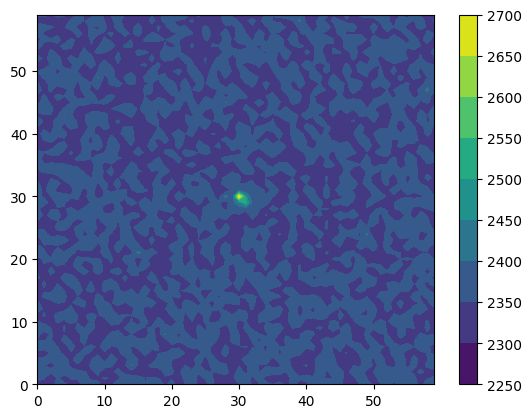

Estrela 34: 


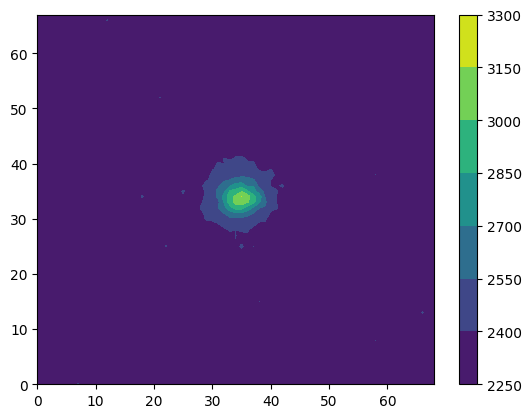

Estrela 35: 


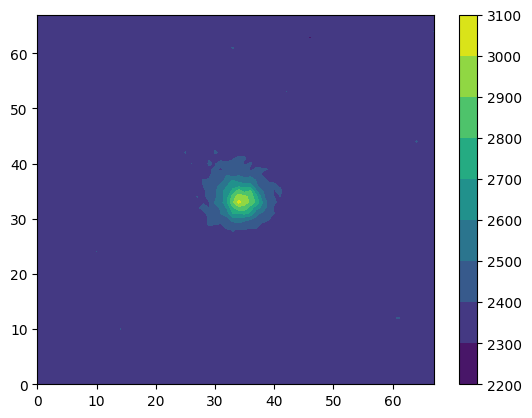

Estrela 36: 


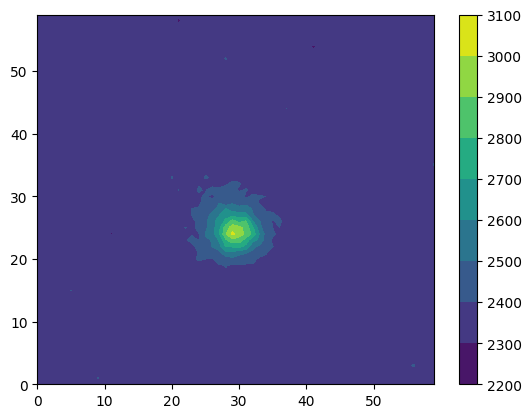

Estrela 37: 


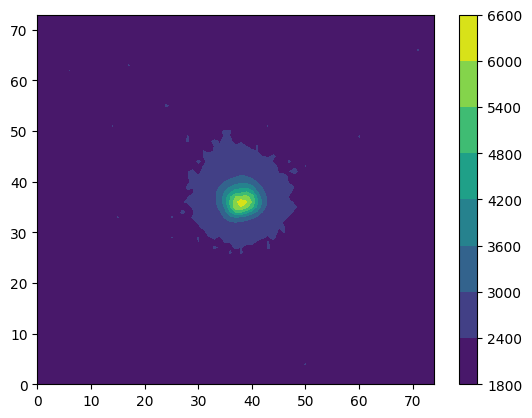

Estrela 38: 


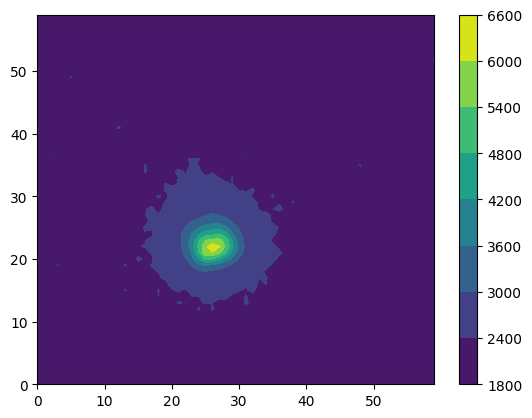

Estrela 39: 


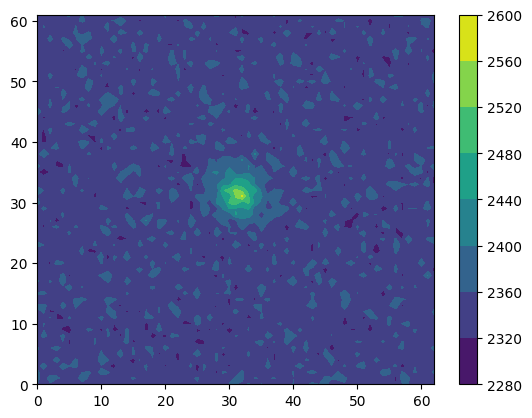

Estrela 40: 


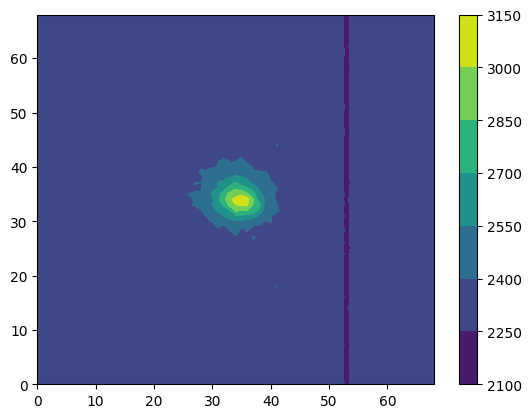

Estrela 41: 


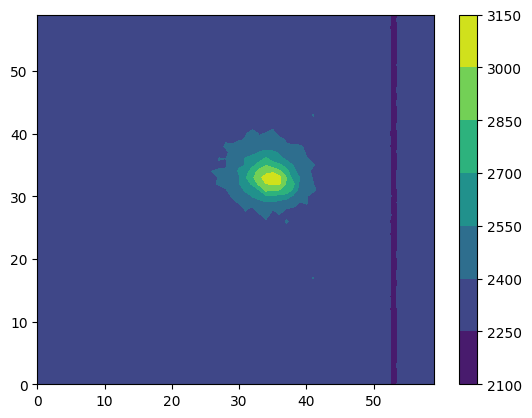

Estrela 42: 


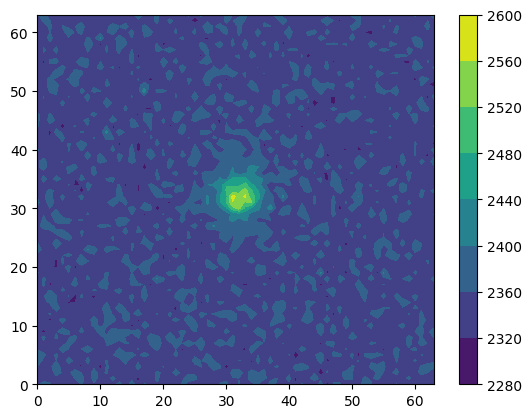

Estrela 43: 


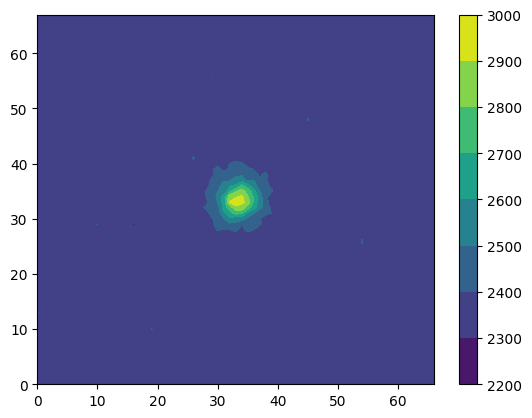

Estrela 44: 


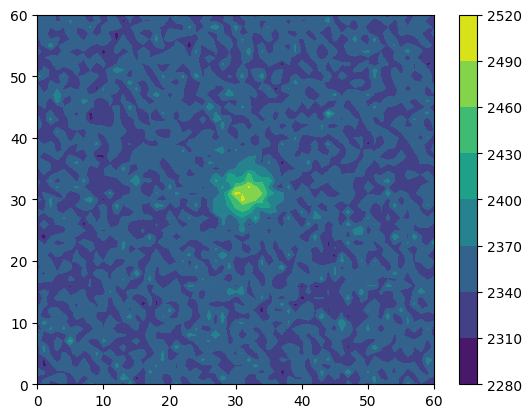

Estrela 45: 


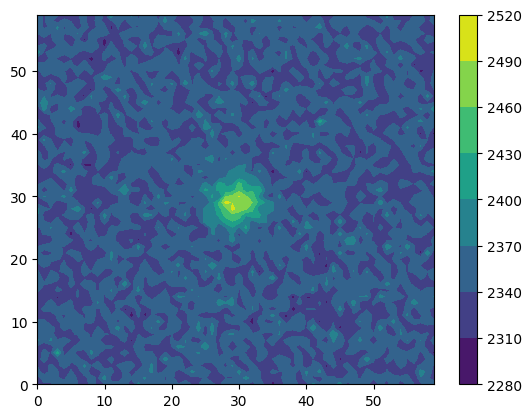

Estrela 46: 


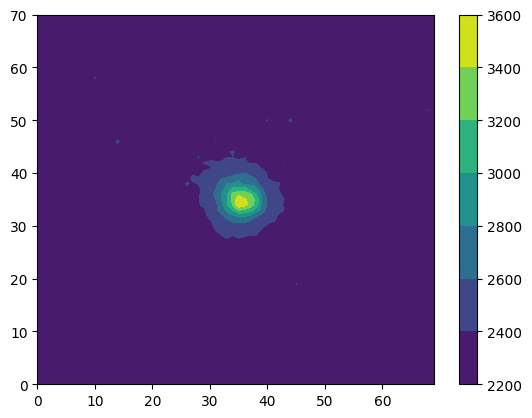

Estrela 47: 


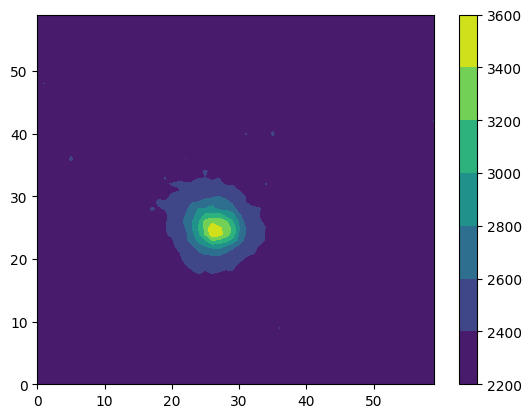

Estrela 48: 


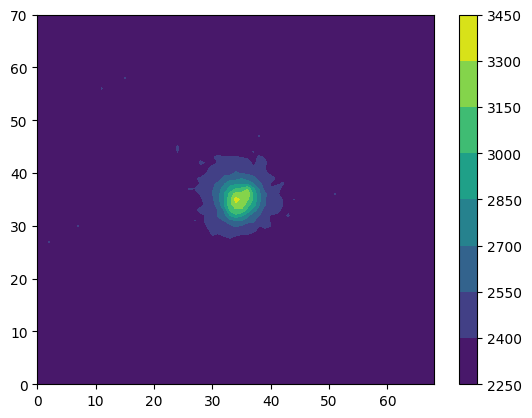

Estrela 49: 


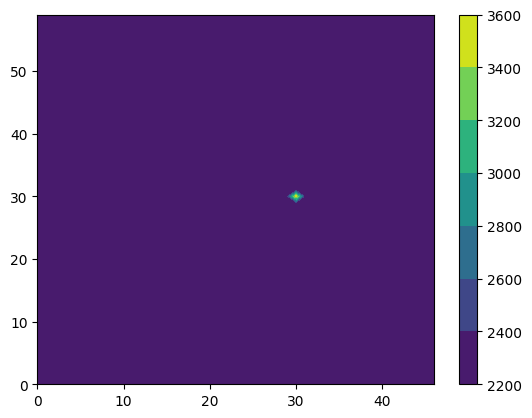

Estrela 50: 


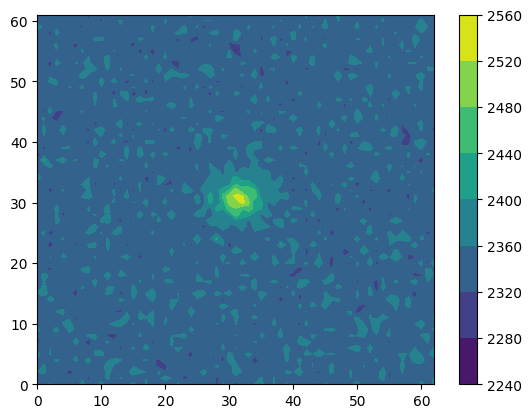

In [131]:
# Plotando cada estrela individualmente

pImage.plotar_estrelas(lista_coord_estrelas, option=1)

Observando as plotagens individuais, podemos ver que estes picos realmente caracterizam estrelas. Podemos notar também que, o método foi capaz de detectar estrelas de menor luminosidade.